### Environment

In [1]:
%load_ext autoreload
%autoreload 2
%pylab
%matplotlib inline

import pandas as pd
import pickle
import numpy as np
import sys
import os

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
sys.path.append('../')
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

### Configuration

In [3]:
from sv_system.utils.parser import set_train_config
import easydict

args = easydict.EasyDict(dict(dataset="voxc1_fbank_xvector", 
                              data_folder="/dataset/SV_sets/voxceleb12/feats/fbank64_vad/",
                              input_frames=400, splice_frames=[200, 400], stride_frames=1, 
                              input_format='fbank', input_dim=65, random_clip=True,
                              n_epochs=120, lrs=[0.1, 0.01], lr_schedule=[20], seed=1337,
                              no_eer=False, batch_size=64,
                              gpu_no=[0], cuda=True, num_workers=4,
                              arch="tdnn_conv", loss="softmax",
                             ))
config = set_train_config(args)

### Dataset

In [4]:
dev_df = pd.read_csv("/dataset/SV_sets/voxceleb1/dataframes/voxc1_dev.csv")
spk_counts = dev_df.spk.value_counts()
small_set_spks = spk_counts[:300].index
dev_df = dev_df[dev_df.spk.isin(small_set_spks)]
dev_df['label'] = dev_df.groupby('spk').ngroup()
dev_train_df = dev_df[dev_df.set == 'train']
dev_val_df = dev_df[dev_df.set == 'val']

In [5]:
eval_df = pd.read_csv("/dataset/SV_sets/voxceleb1/dataframes/voxc1_eval.csv")
eval_df = eval_df[eval_df.spk.isin(small_set_spks)]
eval_df['label'] = eval_df.groupby('spk').ngroup()

In [6]:
from sv_system.data.feat_dataset import FeatDataset

dev_train_dataset = FeatDataset.read_df(config, dev_train_df, 'train')
dev_val_dataset = FeatDataset.read_df(config, dev_val_df, 'test')
eval_dataset = FeatDataset.read_df(config, eval_df, 'test')

### Dataloader

In [7]:
from sv_system.data.dataloader import init_default_loader 
dev_train_dataloader = init_default_loader(config, dev_train_dataset, shuffle=True, var_len=False) 
dev_val_dataloader = init_default_loader(config, dev_val_dataset, shuffle=False, var_len=False) 
eval_dataloader = init_default_loader(config, eval_dataset, shuffle=False, var_len=True) 

### Model

In [30]:
import torch
from tdnn_models import tdnn_xvector_se
from tdnn_models import tdnn_xvector

model = tdnn_xvector_se(config, 512, n_labels=len(dev_df.label.unique()))
# saved_model = torch.load("trained_models/voxc1_small_dev_time_reduction.pt")
# model.load_state_dict(saved_model)

if not config['no_cuda']:
    model = model.cuda()

In [31]:
import torch.nn as nn
from torch.optim import SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau, MultiStepLR
from sklearn.metrics import roc_curve
import torch.nn.functional as F
from tensorboardX import SummaryWriter

optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)
from fine_tune_utils import class_weight
# criterion = nn.CrossEntropyLoss(weight=class_weight(config, dev_train_df))
criterion = nn.CrossEntropyLoss()
plateau_scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5)
# step_scheduler = MultiStepLR(optimizer, [30], 0.1)

writer = SummaryWriter("logs/tdnn_xvector_vox1_small_baseline")
model_path = "trained_models/voxc1_small_dev_tdnn_xvector.pt"

for epoch_idx in range(0, config['n_epochs']):
    print("-"*30)
    curr_lr = optimizer.state_dict()['param_groups'][0]['lr']
    print("curr_lr: {}".format(curr_lr))
    
# =============== train code #===============
    model.train()
    loss_sum = 0
    n_corrects = 0
    total = 0
    for batch_idx, (X, y) in enumerate(dev_train_dataloader):
        if not config['no_cuda']:
            X = X.cuda()
            y = y.cuda()

        optimizer.zero_grad()
        logit = model(X)
        loss = criterion(logit, y)
        loss.backward()
        optimizer.step()
                        
        loss_sum += loss.item()
        n_corrects += logit.max(1)[1].eq(y).sum().item()
        total += y.size(0)
#         if (batch_idx+1) % 1000 == 0:
#             print("Batch {}/{}\t Loss {:.6f}" \
#                   .format(batch_idx+1, len(si_loader), loss_sum / total))
    train_loss = loss_sum / total
    train_acc = n_corrects / total
    plateau_scheduler.step(train_loss)
    
    print("epoch #{}, train loss: {:.4f}, train acc: {:.4f}".format(epoch_idx, train_loss, train_acc))
    writer.add_scalar("train/loss", train_loss, epoch_idx+1)
    writer.add_scalar("train/acc", train_acc, epoch_idx+1)

#=============== dev_val code #===============
    model.eval()
    loss_sum = 0
    n_corrects = 0
    total = 0
    for batch_idx, (X, y) in enumerate(dev_val_dataloader):
        if not config['no_cuda']:
            X = X.cuda()
            y = y.cuda()

        logit = model(X)
        loss = criterion(logit, y)
        loss_sum += loss.item()
        n_corrects += logit.max(1)[1].eq(y).sum().item()
        total += y.size(0)
    val_loss = loss_sum / total
    val_acc = n_corrects / total
    
    print("epoch #{}, val loss: {:.4f}, val acc: {:.4f}".format(epoch_idx, val_loss, val_acc))
    writer.add_scalar("val/loss", val_loss, epoch_idx+1)
    writer.add_scalar("val/acc", val_acc, epoch_idx+1)
    
#=============== model save #===============
    torch.save(model.state_dict(), model_path)

------------------------------
curr_lr: 0.01
epoch #0, train loss: 0.0780, train acc: 0.0585
epoch #0, val loss: 0.0713, val acc: 0.0634
------------------------------
curr_lr: 0.01
epoch #1, train loss: 0.0553, train acc: 0.2131
epoch #1, val loss: 0.0566, val acc: 0.1740
------------------------------
curr_lr: 0.01
epoch #2, train loss: 0.0381, train acc: 0.4275
epoch #2, val loss: 0.0450, val acc: 0.3078
------------------------------
curr_lr: 0.01
epoch #3, train loss: 0.0252, train acc: 0.6113
epoch #3, val loss: 0.0381, val acc: 0.4025
------------------------------
curr_lr: 0.01
epoch #4, train loss: 0.0165, train acc: 0.7445
epoch #4, val loss: 0.0328, val acc: 0.4844
------------------------------
curr_lr: 0.01
epoch #5, train loss: 0.0107, train acc: 0.8340
epoch #5, val loss: 0.0260, val acc: 0.5890
------------------------------
curr_lr: 0.01
epoch #6, train loss: 0.0072, train acc: 0.8890
epoch #6, val loss: 0.0229, val acc: 0.6399
------------------------------
curr_lr: 0

Process Process-687:
Process Process-688:
Process Process-685:
Process Process-686:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/envs/pytorch-py3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/envs/pytorch-py3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/envs/pytorch-py3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/envs/pytorch-py3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/envs/pytorch-py3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/envs/pytorch-py3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/o

KeyboardInterrupt: 

In [33]:
a = torch.load("../sv_system/saved_models/best_models/voxc2/voxc2_fbank64_untied_model.pth.tar")

In [10]:
## =============== dev_val code #===============
model.eval()
loss_sum = 0
n_corrects = 0
total = 0
for batch_idx, (X, y) in enumerate(dev_val_dataloader):
    if not config['no_cuda']:
        X = X.cuda()
        y = y.cuda()

    logit = model(X)
    loss = criterion(logit, y)
    loss_sum += loss.item()
    n_corrects += logit.max(1)[1].eq(y).sum().item()
    total += y.size(0)
val_loss = loss_sum / total
val_acc = n_corrects / total

print("epoch #{}, val loss: {:.4f}, val acc: {:.4f}".format(epoch_idx, val_loss, val_acc))

NameError: name 'criterion' is not defined

In [11]:
# See, Attention map
att_maps = []
model.eval()
total = 0
for batch_idx, (X, y) in enumerate(dev_train_dataloader):
    if not config['no_cuda']:
        X = X.cuda()
        y = y.cuda()

    att_map = model.att_map(X).cpu().detach().numpy()
    att_maps.append(att_map)
    break
    

In [22]:
# See, Fr features
fr_feats = []
model.eval()
total = 0
for batch_idx, (X, y) in enumerate(dev_val_dataloader):
    if not config['no_cuda']:
        X = X.cuda()
        y = y.cuda()

    fr_feat = model.fr_feat(X).cpu().detach()
    fr_feats.append(fr_feat)
    break

In [23]:
from torch.nn.functional import cosine_similarity as cosine
cosine(fr_feats[0][0,:,0:1], fr_feats[0][0,:,1:], dim=0)

tensor([0.4115, 0.4619, 0.2880, 0.1456, 0.2449, 0.2377, 0.1846, 0.2711, 0.3090,
        0.2152, 0.3659, 0.2667, 0.3660, 0.3011, 0.2163, 0.4169, 0.4812, 0.4101,
        0.3309, 0.3308, 0.3580, 0.2597, 0.3758, 0.0898, 0.4742, 0.2708, 0.1194,
        0.3323, 0.1286, 0.2033, 0.1993, 0.2460, 0.2657, 0.3245, 0.3804, 0.3026,
        0.1827, 0.2627, 0.2961, 0.2626, 0.3103, 0.3536, 0.5638, 0.2204, 0.3099,
        0.2129])

In [17]:
fr_feats[0][1].shape

torch.Size([1500, 47])

(array([ 2.,  1.,  0.,  0.,  0.,  0.,  0.,  0., 18., 26.]),
 array([0.00847906, 0.00992662, 0.01137418, 0.01282174, 0.0142693 ,
        0.01571687, 0.01716443, 0.01861199, 0.02005955, 0.02150711,
        0.02295467], dtype=float32),
 <a list of 10 Patch objects>)

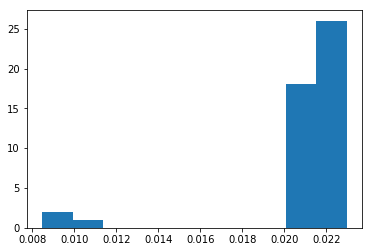

In [42]:
plt.hist(att_maps[0][15])

In [43]:
att_maps[0][15]

array([0.02295467, 0.02295467, 0.02223028, 0.02295467, 0.02295467,
       0.02295467, 0.02113651, 0.02113651, 0.02295467, 0.02295467,
       0.00886847, 0.01112725, 0.02295467, 0.02295467, 0.02113651,
       0.02182527, 0.02295467, 0.02193193, 0.02295467, 0.02113651,
       0.02113651, 0.02295467, 0.02113651, 0.02113651, 0.02113651,
       0.02295467, 0.02295467, 0.02223028, 0.02113651, 0.02113651,
       0.02113651, 0.02113651, 0.02182527, 0.02295467, 0.00847906,
       0.02295467, 0.02295467, 0.02193193, 0.02295467, 0.02295467,
       0.02295467, 0.02113651, 0.02113651, 0.02113651, 0.02113651,
       0.02113651, 0.02113651], dtype=float32)

### LDA on embedding

In [20]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

global_mean = si_embeds.mean(0)
clf = LDA(solver='svd', n_components=200)
clf.fit(si_embeds - global_mean, si_key_df.label)

si_embeds = clf.transform(si_embeds - global_mean).astype(np.float32)

sv_embeds = clf.transform(sv_embeds - global_mean).astype(np.float32)

si_dataset, embed_dim, n_labels = embedToDataset(si_embeds.reshape(-1,200), si_key_df)
sv_dataset, _, _ = embedToDataset(sv_embeds, sv_key_df)